# 1. Libraries & Sample Data
The first step is to load our Python Libraries and download the sample data. The dataset represents Apple stock price (1d bars) for the year 2010

In [1]:
# Load Python Libraries
import math
import keras
import random
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import deque
from tqdm.notebook import tqdm
from IPython.display import display, HTML

# for dataframe display
pd.set_option("display.max_rows", None)
def display_df(df):
    # Puts the scrollbar next to the DataFrame
    display(HTML("<div style='height: 200px; overflow: auto; width: fit-content'>" + df.to_html() + "</div>"))

# for reproducability of answers
keras.utils.set_random_seed(42)


In [2]:
# Download Sample Data AAPL_2009_4m_training_features_1d (cleaned, not normalized, with features)
data = pd.read_csv('AAPL_2009_4m_training_features_1d.csv')
# track index to remember which feature is which
idx_close = 0
idx_bb_upper = 1
idx_bb_lower = 2

# 2. Train / Test Split
Now that we have loaded our cleaned price dataset, we are ready to feed the data into our model. With this in mind, we select Close as our singular training feature, and split the data ito train and test data (80/20 split)

In [3]:
# split dataset df into train (80%) and test (20%) datasets
training_rows = int(len(data.index)*0.8)
train_df = data.loc[:training_rows].set_index("Date")
test_df = data.loc[training_rows+1:].set_index("Date")

In [4]:
# display train and test dfs (ensure no overlap)
display_df(train_df)
display_df(test_df)

,Close,BB_upper,BB_lower
Date,,,
2009-04-30,4.493929,4.576559,4.040905
2009-05-01,4.544286,4.587013,4.082345
2009-05-04,4.544286,4.606655,4.102880
2009-05-05,4.739643,4.677963,4.082501
2009-05-06,4.732143,4.732943,4.077699
2009-05-07,4.609286,4.745322,4.110821
2009-05-08,4.613929,4.763748,4.126752
2009-05-11,4.627500,4.781972,4.141921
2009-05-12,4.627500,4.789788,4.174320


,Close,BB_upper,BB_lower
Date,,,
2009-06-19,4.981429,5.287810,4.542011
2009-06-22,4.906071,5.214837,4.668092
2009-06-23,4.786071,5.200695,4.693770
2009-06-24,4.786071,5.197255,4.700638
2009-06-25,4.995000,5.199378,4.715622
2009-06-26,5.087143,5.210573,4.730748
2009-06-29,5.070357,5.219369,4.731310
2009-06-30,5.086786,5.229668,4.731510


In [5]:
# convert train and test dfs to np arrays with dtype=float
X_train = train_df.values.astype(float)
X_test = test_df.values.astype(float)
# print the shape of X_train to remind yourself how many examples and features are in the dataset
X_train.shape

(35, 3)

# 3. Define the Agent
Now that our data is ready to use, we can define the Reinforcement Learning Agent.

### Define the DQN Model
The first step in defining our agent is the Deep Q-Network model definition. For this excercise, we are creating a sequential model with three layers. The first two layers have output shape of 32 and 8, respectively, and a RELU activation. The output layer has an output shape of the size of our action space (buy, sell, hold), and a linear activation. Our Loss function is Mean Squared Error, and our optimizer is Adam with a learning rate of 0.001. Use Keras to build this model.

In [6]:
@keras.saving.register_keras_serializable()
# Define DQN Model Architecture
class DQN(keras.Model):
    def __init__(self, state_size, action_size):
    
        model = keras.models.Sequential()
        #Input Layer
        model.add(keras.layers.Dense(units=32, input_dim=state_size, activation="relu"))
        #Hidden Layer
        model.add(keras.layers.Dense(units=8, activation="relu"))
        #Output Layer 
        model.add(keras.layers.Dense(action_size, activation="linear"))
        model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=0.001))

        self.model = model


### Define Agent Class
Now that we have defined our underlying DQN Model, we must define out Reinforcement Learning Agent. The agent initialization is provided for you, you must define an act function, and an expereince replay function. As a reminder, the act function defines how our model will act (buy, hold, or sell) given a certain state. The Experience Replay function tackles catastrophic forgetting in our training process, by maintaining a memory buffer to allow training on independent / randomized minibatches of previous states. 

In [7]:
class Agent:
    def __init__(self, window_size, num_features, test_mode=False, model_name=''):
        self.window_size = window_size # How many days of historical data do we want to include in our state representation?
        self.num_features = num_features # How many training features do we have?
        self.state_size = window_size*num_features # State size includes number of training features per day, and number of lookback days 
        self.action_size = 3 # 0=hold, 1=buy, 2=sell
        self.memory = deque(maxlen=1000) # Bound memory size: once the memory reaches 1000 units, the lefthand values are discarded as righthand values are added
        self.inventory = [] # Inventory to hold trades
        self.model_name = model_name # filename for saved model checkpoint loading
        self.test_mode = test_mode # flag for testing (allows model load from checkpoint model_name)

        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        
        self.model = keras.models.load_model(model_name) if test_mode else self._model()


    #Deep Q Learning (DQL) model
    def _model(self):
        model = DQN(self.state_size, self.action_size).model
        return model
    

    # DQL Predict (with input reshaping)
    #   Input = State
    #   Output = Q-Table of action Q-Values
    def get_q_values_for_state(self, state):
        return self.model.predict(state.flatten().reshape(1, self.state_size))
    

    # DQL Fit (with input reshaping)
    #   Input = State, Target Q-Table 
    #   Output = MSE Loss between Target Q-Table and Actual Q-Table for State
    def fit_model(self, input_state, target_output):
        return self.model.fit(input_state.flatten().reshape(1, self.state_size), target_output, epochs=1, verbose=0)    
    

    # Agent Action Selector
    #   Input = State
    #   Policy = epsilon-greedy (to minimize possibility of overfitting)
    #   Intitially high epsilon = more random, epsilon decay = less random later
    #   Output = Action (0, 1, or 2)
    def act(self, state): 
        # Choose any action at random (Probablility = epsilon for training mode, 0% for testing mode)
        if not self.test_mode and random.random() <= self.epsilon:
            return random.randrange(self.action_size)   
        # Choose the action which has the highest Q-value (Probablitly = 1-epsilon for training mode, 100% for testing mode)
        options = self.get_q_values_for_state(state)
        return np.argmax(options[0]) 

    # Experience Replay (Learning Function)
    #   Input = Batch of (state, action, next_state) tuples
    #   Optimal Q Selection Policy = Bellman equation
    #   Important Notes = Model fitting step is in this function (fit_model)
    #                     Epsilon decay step is in this function
    #   Output = Model loss from fitting step
    def exp_replay(self, batch_size):
        losses = []
        mini_batch = []
        l = len(self.memory)
        for i in range(l - batch_size + 1, l):
            mini_batch.append(self.memory[i])
            
        for state, action, reward, next_state, done in mini_batch:
            # reminders: 
            #   - state is a vector containing close & MA values for the current time step
            #   - action is an integer representing the action taken by the act function at the current time step- buy, hold, or sell
            #   - reward represents the profit of a given action - it is either 0 (for buy, hold, and sells which loose money) or the profit in dollars (for a profitable sell)
            #   - next_state is a vector containing close & MA values for the next time step
            #   - done is a boolean flag representing whether or not we are in the last iteration of a training episode (i.e. True when next_state does not exist.)
            
            if done:
                # special condition for last training epoch in batch (no next_state)
                optimal_q_for_action = reward  
            else:
                # target Q-value is updated using the Bellman equation: reward + gamma * max(predicted Q-value of next state)
                optimal_q_for_action = reward + self.gamma * np.max(self.get_q_values_for_state(next_state))
            # Get the predicted Q-values of the current state
            target_q_table = self.get_q_values_for_state(state)  
            # Update the output Q table - replace the predicted Q value for action with the target Q value for action 
            target_q_table[0][action] = optimal_q_for_action
            # Fit the model where state is X and target_q_table is Y
            history = self.fit_model(state, target_q_table)
            losses += history.history['loss']

        # define epsilon decay (for the act function)     
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return losses

/Users/rnmourao/.pyenv/versions/3.12.1/envs/ds-basic-3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


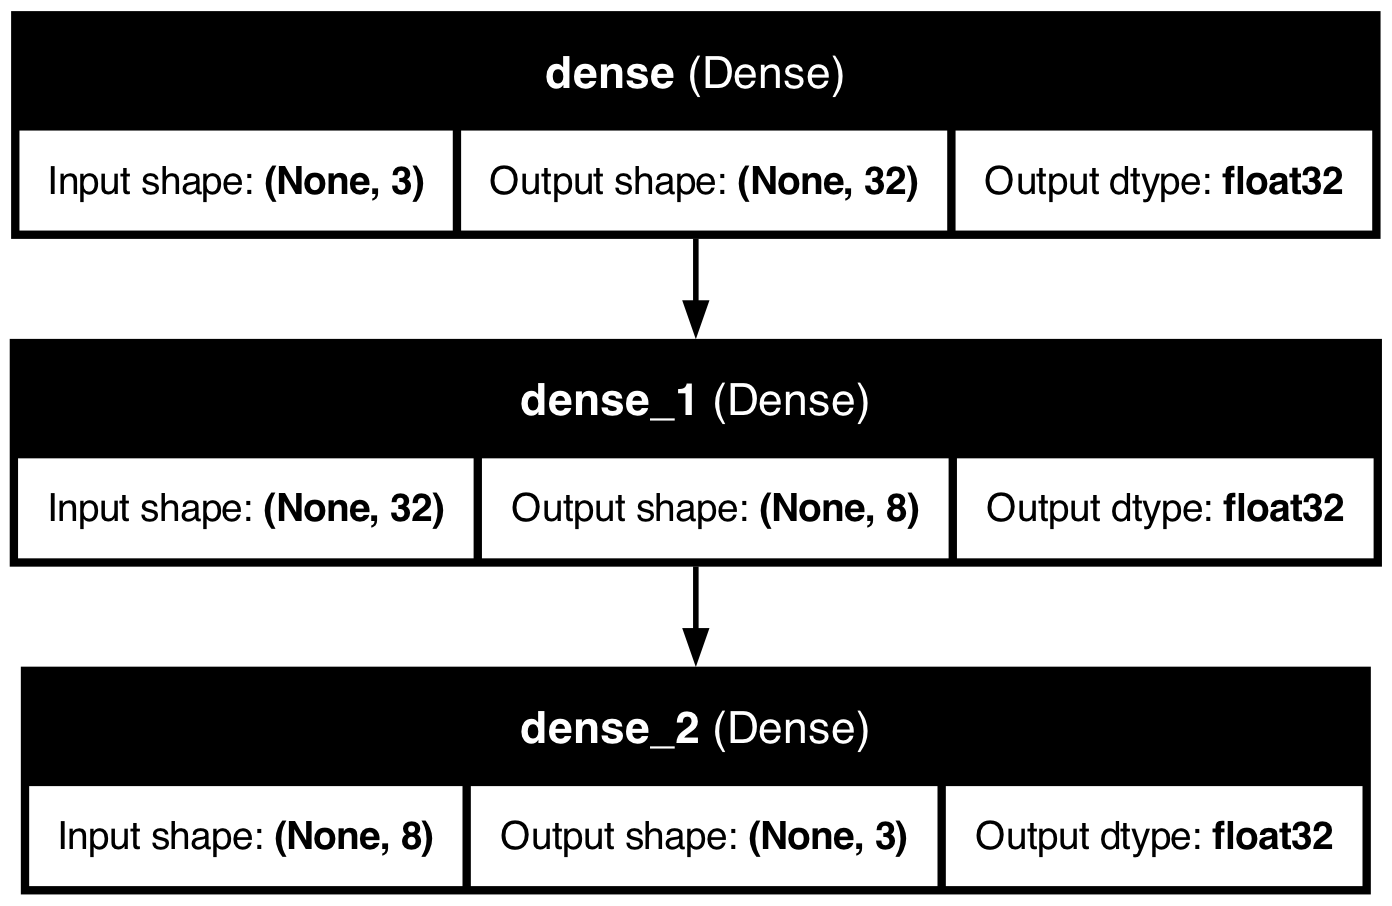

In [8]:
keras.utils.disable_interactive_logging()
from tqdm.notebook import tqdm

window_size = 1
agent = Agent(window_size, num_features=X_train.shape[1])
dot = keras.utils.model_to_dot(
    agent.model,
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
)
dot.write("model.png", format='png')
from IPython import display

display.Image('model.png')

# 4. Train the Agent
Now that our agent is defined, we are ready to train it. 

### Helper Functions
Before we define the training loop, we will write some helper functions: one for printing price data, one to define the sigmoind funtion, one to grab the state representation, and one to plot the output of our trained model. The printing, sigmoid, and plotting functions are defined for you. You must define the function which gets the state representation.

In [9]:
# Format price string
def format_price(n):
    return ('-$' if n < 0 else '$') + '{0:.2f}'.format(abs(n))

def sigmoid(x):
    return 1 / (1 + math.exp(-x))

# Plot behavior of trade output
def plot_behavior(data_input, bb_upper_data, bb_lower_data, states_buy, states_sell, profit, train=True):
    fig = plt.figure(figsize = (15,5))
    plt.plot(data_input, color='k', lw=2., label= 'Close Price')
    plt.plot(bb_upper_data, color='b', lw=2., label = 'Bollinger Bands')
    plt.plot(bb_lower_data, color='b', lw=2.)
    plt.plot(data_input, '^', markersize=10, color='r', label = 'Buying signal', markevery = states_buy)
    plt.plot(data_input, 'v', markersize=10, color='g', label = 'Selling signal', markevery = states_sell)
    plt.title('Total gains: %f'%(profit))
    plt.legend()
    if train:
        plt.xticks(range(0, len(train_df.index.values), int(len(train_df.index.values)/15)), train_df.index.values[0:: int(len(train_df.index.values)/15)], rotation=45, fontsize='small')
    else:
        plt.xticks(range(0, len(test_df.index.values), int(len(test_df.index.values)/2)), test_df.index.values[0::int(len(test_df.index.values)/2)], rotation=45, fontsize='small')
    plt.show()

# Plot training loss
def plot_losses(losses, title):
    plt.plot(losses)
    plt.title(title)
    plt.ylabel('MSE Loss Value')
    plt.xlabel('batch')
    plt.show()
    

# returns an an n-day state representation ending at time t
def get_state(data, t, n):    
    d = t - n
    if d >= 0:
        block = data[d:t] 
    else:
        block =  np.array([data[0]]*n) 
    res = []
    for i in range(n - 1):
        feature_res = []
        for feature in range(data.shape[1]):
            feature_res.append(sigmoid(block[i + 1, feature] - block[i, feature]))
        res.append(feature_res)
    # display(res)
    return np.array([res])

### Training Loop

In [10]:
# display the shape of your training data in order to remond yourself how may features and examples there are in your training set
X_train.shape

(35, 3)

Running episode 0/1:   0%|          | 0/34 [00:00<?, ?it/s]

Buy: $4.39
Buy: $4.55
Buy: $4.43
Buy: $4.38
Buy: $4.67
Sell: $4.82 | Profit: $0.43
Buy: $4.82
Buy: $4.98
Sell: $4.98 | Profit: $0.43
Buy: $5.03
Sell: $5.13 | Profit: $0.70
Sell: $5.17 | Profit: $0.79
Buy: $5.17
Buy: $5.01
Sell: $5.00 | Profit: $0.33
Sell: $4.86 | Profit: $0.04
Sell: $4.84 | Profit: -$0.13
--------------------------------
Episode 0
Total Profit: $2.58
Total Winners: $2.72
Total Losers: -$0.13
Max Loss: 0.736491305342728
Total Loss: 0.736491305342728
--------------------------------


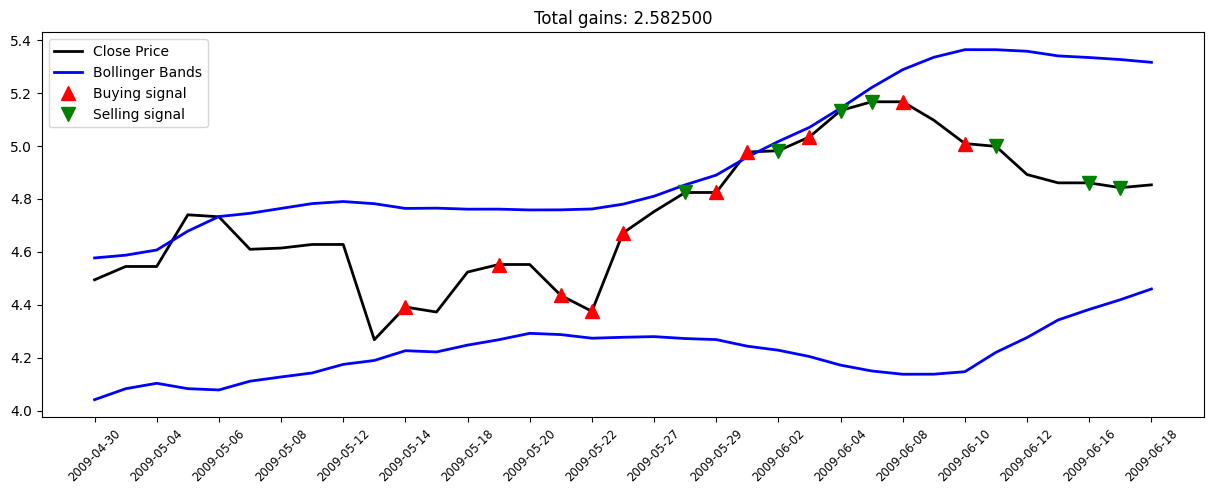

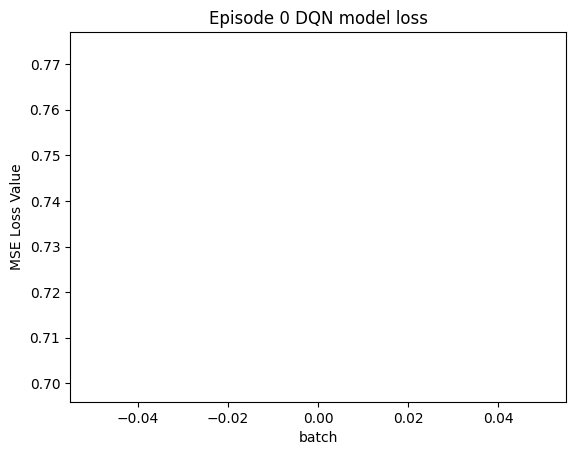

Running episode 1/1:   0%|          | 0/34 [00:00<?, ?it/s]

Buy: $4.54
Sell: $4.74 | Profit: $0.20
Buy: $4.63
Sell: $4.27 | Profit: -$0.36
Buy: $4.39
Buy: $4.37
Sell: $4.52 | Profit: $0.13
Buy: $4.55
Sell: $4.55 | Profit: $0.18
Buy: $4.43
Buy: $4.38
Buy: $4.67
Buy: $4.98
Buy: $5.03
Buy: $5.13
Sell: $5.17 | Profit: $0.62
Sell: $5.01 | Profit: $0.57
Sell: $5.00 | Profit: $0.62
Buy: $4.89
Buy: $4.86
Sell: $4.86 | Profit: $0.19
Sell: $4.84 | Profit: -$0.14
--------------------------------
Episode 1
Total Profit: $2.01
Total Winners: $2.51
Total Losers: -$0.50
Max Loss: 1.14674314966976
Total Loss: 25.454116535195645
--------------------------------


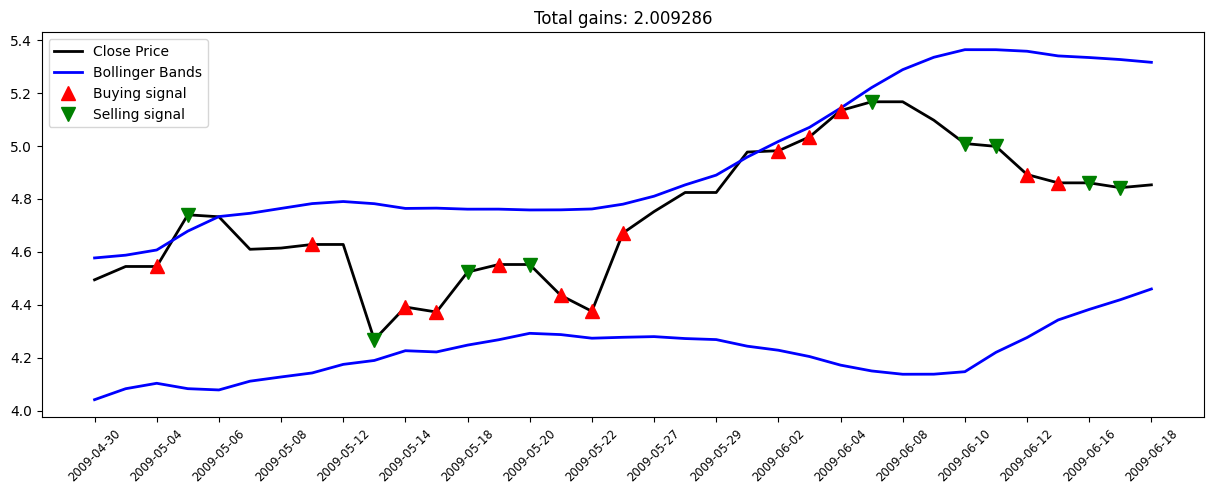

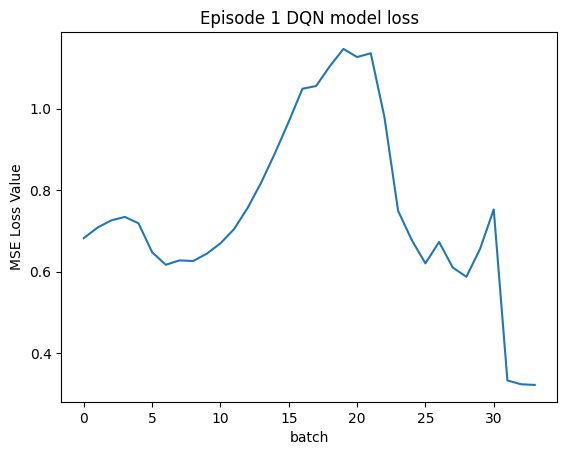

In [11]:
keras.config.disable_traceback_filtering()  # disable built-in keras loading bars - they make the output difficult to read and monitor

# track number of examples in dataset (i.e. number of days to train on)
l = X_train[:,0].shape[0] - 1

# batch size defines how often to run the exp_replay method
batch_size = 32

#An episode represents a complete pass over the data.
episode_count = 1

batch_losses = []
num_batches_trained = 0

for e in range(episode_count + 1):
    state = get_state(X_train, 0, window_size + 1)
    # initialize variables
    total_profit = 0
    total_winners = 0
    total_losers = 0
    agent.inventory = []
    states_sell = []
    states_buy = []
    for t in tqdm(range(l), desc=f'Running episode {e}/{episode_count}'):
        action = agent.act(state)   
        next_state = get_state(X_train, t + 1, window_size + 1)

        # initialize reward for the current time step
        reward = 0

        if action == 1: # buy
            # inverse transform to get true buy price in dollars
            buy_price = X_train[t, idx_close]
            agent.inventory.append(buy_price)
            states_buy.append(t)
            print(f'Buy: {format_price(buy_price)}')

        elif action == 2 and len(agent.inventory) > 0: # sell
            bought_price = agent.inventory.pop(0)  
            # inverse transform to get true sell price in dollars
            sell_price = X_train[t, idx_close]

            # define reward as max of profit (close price at time of sell - close price at time of buy) and 0 
            trade_profit = sell_price - bought_price
            reward = max(trade_profit, 0)
            total_profit += trade_profit
            if trade_profit >=0:
                total_winners += trade_profit
            else:
                total_losers += trade_profit
            states_sell.append(t)
            print(f'Sell: {format_price(sell_price)} | Profit: {format_price(trade_profit)}')
        
        # flag for final training iteration
        done = True if t == l - 1 else False
        # append the details of the state action etc in the memory, to be used by the exp_replay function        
        agent.memory.append((state, action, reward, next_state, done))
        state = next_state
        # print total profit and plot behaviour of the current episode when the episode is finished
        if done:
            print('--------------------------------')
            print(f'Episode {e}')
            print(f'Total Profit: {format_price(total_profit)}')
            print(f'Total Winners: {format_price(total_winners)}')
            print(f'Total Losers: {format_price(total_losers)}')
            print(f'Max Loss: {max(batch_losses[num_batches_trained:len(batch_losses)])}')
            print(f'Total Loss: {sum(batch_losses[num_batches_trained:len(batch_losses)])}')
            print('--------------------------------')
            plot_behavior(X_train[:, idx_close].flatten(), X_train[:, idx_bb_upper].flatten(), X_train[:, idx_bb_lower].flatten(), states_buy, states_sell, total_profit)
            plot_losses(batch_losses[num_batches_trained:len(batch_losses)], f'Episode {e} DQN model loss')
            num_batches_trained = len(batch_losses)

        if len(agent.memory) > batch_size:
            # when the size of the memory is greater than the batch size, run the exp_replay function on the batch to fit the model and get losses for the batch
            losses = agent.exp_replay(batch_size)    
            # then sum the losses for the batch and append them to the batch_losses list
            batch_losses.append(sum(losses))

    agent.model.save(f'model_ep{e}.keras')


# 5. Test the trained model 
Finally, we get to test our trained model to see how well it performs in our test set. Using the training loop above, define a method to run our trained model on our X_test dataset. 

## Define Parameters
Some test parameters are defined for you below. Fill out the missing data. If you need a hint, look up at the training loop. 

In [ ]:
l_test = len(X_test) - 1
state = get_state(X_test, 0, window_size + 1)
total_profit = 0
done = False
states_sell_test = []
states_buy_test = []

#Get the trained model
agent = Agent(window_size, num_features=X_test.shape[1], test_mode=True, model_name=f'model_ep{episode_count}.keras')
agent.inventory = []

In [ ]:
for t in range(l_test):
    action = agent.act(state)
    next_state = get_state(X_test, t + 1, window_size + 1)
    reward = 0

    if action == 1: # buy
        # inverse transform to get true buy price in dollars
        buy_price = X_test[t, idx_close]
        agent.inventory.append(buy_price)
        states_buy_test.append(t)
        print(f'Buy: {format_price(buy_price)}')

    elif action == 2 and len(agent.inventory) > 0: # sell
        bought_price = agent.inventory.pop(0)  
        # inverse transform to get true sell price in dollars
        sell_price = X_test[t, idx_close]

        # reward is max of profit (close price at time of sell - close price at time of buy)
        reward = max(sell_price - bought_price, 0)
        total_profit += sell_price - bought_price
        states_sell_test.append(t)
        print(f'Sell: {format_price(sell_price)} | Profit: {format_price(sell_price - bought_price)}')


    if t == l_test - 1:
        done = True
    
    # append to memory so we can re-train on 'live' (test) data later    
    agent.memory.append((state, action, reward, next_state, done))
    state = next_state

    if done:
        print('------------------------------------------')
        print(f'Total Profit: {format_price(total_profit)}')
        print('------------------------------------------')
        
plot_behavior(X_test[:, idx_close].flatten(),X_test[:, idx_bb_upper].flatten(), X_test[:, idx_bb_lower].flatten(), states_buy_test, states_sell_test, total_profit, train=False)